In [1]:
# Prep training data
from copyreg import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import sys
from tkinter import Y
import gzip
import itertools
import numpy as np
import pandas as pd
import pickle as pk
import torch
import gpytorch
import plotly.express as px
sys.path.append('..')
sys.path.insert(0, '../src')

In [2]:
from model import GPModel
from acq_funcs import EI, PI, cust_acq, thompson
from plotter import vis_pred, vis_acq

### Data Read and Pre-processing

In [3]:
# read data and display
def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    # plot each cross-section
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"])
    fig.update_layout(margin=dict(r=20, l=10, b=10, t=10))
    fig.update_layout(height=1000)
    fig.show()

In [4]:
# get training set from dataframe
def datasetmaker(fe_data):
    """
    [datasetmaker(fe_data)] filters and transforms the data in pandas df [fe_data] 
    into two tensors, [train_x] for input and [train_y] for output tensors. 
    """
    # define standardizer
    norm_arr = lambda arr, mean, sd: (arr - mean)/sd
    
    # filter training data 
    energy_den = fe_data['Energy density new cone (J/cm^2)'].values
    time = fe_data['Time (ms)'].values
    train_x = torch.Tensor([energy_den, time]).T
    train_y = torch.Tensor(fe_data['2 Qsw/(U+|D|) 1e6cycles'].values)

    # standardizer inputs; col_mean, col_sd are tuples of mean/sd per column of x
    x_sd_mean = torch.std_mean(train_x, axis=0)
    train_x = norm_arr(train_x, x_sd_mean[1], x_sd_mean[0])

    # standardizer outputs
    y_sd_mean = torch.std_mean(train_y, axis=0)
    train_y = norm_arr(train_y, y_sd_mean[1], y_sd_mean[0])
    
    return x_sd_mean, y_sd_mean, train_x, train_y

In [5]:
# undo normalization
def un_norm(arr, arr_sd_mean): return arr*arr_sd_mean[0] + arr_sd_mean[1]

def un_norm_all(x_sd_mean, y_sd_mean, train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf):
    raw_train_x = un_norm(train_x, x_sd_mean)
    raw_test_grid = un_norm(test_grid, x_sd_mean)

    raw_train_y = un_norm(train_y, y_sd_mean)
    raw_pred_labels = un_norm(pred_labels, y_sd_mean)
    raw_upper_surf = un_norm(torch.Tensor(upper_surf), y_sd_mean)
    raw_lower_surf = un_norm(torch.Tensor(lower_surf), y_sd_mean)

    return raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels, raw_upper_surf, raw_lower_surf

In [6]:
fe_data = read_dat()
print(fe_data)

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4         0.5                              2.73                 0.873026
5         0.5                              3.40                 2.677245
6         1.0                              3.79                 1.699015
7         1.0                              6.44                 3.805053
8         1.5                              5.36                 3.334856
9         1.5                              8.99                 4.535153
11        5.0                              8.80                 1.362510
13        5.0                             14.67                 3.841291
19        0.5                              5.24                 1.201357
22        5.0                             14.89                 3.513652
23        2.0                             10.13                 3.470871
24        0.5                              4.51                 0.263298
25        0.5                              5.37    

In [7]:
display_data(fe_data)

In [8]:
# make training data, maintain params to de-normalize
x_sd_mean, y_sd_mean, train_x, train_y = datasetmaker(fe_data)

/var/folders/1x/23xb47sx0675p75hlkw93bfr0000gn/T/ipykernel_82021/3703217959.py:13: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/torch/csrc/utils/tensor_new.cpp:233.)



### Grid/Parameter Space

In [9]:
# create grid for grid search
def grid_helper(grid_size, num_params, grid_bounds):
    """
    [grid_helper(grid_size, num_params, grid_bounds)] returns a grid of dimensions
    [grid_size] by [num_params], filled in with data from array [grid_bounds]. This
    grid dictates the parameter space for GP to be conducted over. 
    """
    grid = torch.zeros(grid_size, num_params)
    f_grid_diff = lambda i, x, y : float((x[i][1] - x[i][0]) / (y-2))
    for i in range(num_params):
        grid_diff = f_grid_diff(i, grid_bounds, grid_size)
        grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                    grid_bounds[i][1] + grid_diff, grid_size)
    return grid

def grid_maker(train_x):
    """
    [grid_maker(train_x)] creates grids to be used for gaussian process predictions.
    It outputs the dimension of the grid [num_params] and two grid utility 
    tensors [test_grid] and [test_x].
    """
    # define grid between bounds of RTA time, RTA temp
    num_params = train_x.size(dim=1)
    grid_bounds = [(train_x[:,i].min(), train_x[:,i].max()) for i in range(num_params)]
    grid = grid_helper(20, num_params, grid_bounds)

    # set up test_grid for predictions
    num_points = 30
    test_grid = grid_helper(num_points, num_params, grid_bounds)

    # create n-D grid with n = num_params
    args = (test_grid[:, i] for i in range(num_params))
    test_x = torch.cartesian_prod(*args)
    test_x.shape
    return num_params, test_grid, test_x


In [10]:
# create grid based on parameter space for search
num_params, test_grid, test_x = grid_maker(train_x)

### Noise Calculations

Our figure of merit, fom, is $2 Q_{sw}/(U+|D|),$ so error propagation would result in a error of $\sigma_{fom} = |fom|\sqrt{{(\sigma_{Q_{sw}}/Q_{sw}})^2+{(\sigma_U^2 + \sigma_{|D|}^2)/(U+|D|)^2)}}$. We have data for $2Pr$ measurements wrt device area. Using the $10\mu$ m $\times 10\mu$ m data, we approximate the error for the figure of merit as simply $\sigma_{2Pr}$, as we do not have $\sigma_U$ or $\sigma_D.$ 


In [11]:
fn = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/P vs area.xlsx"
excel_file = pd.read_excel(fn, sheet_name='Sheet1')
col_2Pr_10by10 = excel_file['10umx10um']
sd = col_2Pr_10by10.std()/col_2Pr_10by10.mean()
print(sd)
print(col_2Pr_10by10)

0.04469365441252401
0     34.57379
1     35.96416
2     33.16083
3     35.96861
4     37.10497
5     35.86549
6     35.81341
7     33.01597
8     35.71753
9     38.37434
10    34.11144
11    33.57596
12    35.15750
13    35.01515
14    36.01072
15    37.04952
16    36.48895
17    35.63807
18    37.36247
19    39.05057
Name: 10umx10um, dtype: float64


### Initialize Model

In [29]:
# configuration parameters for training
class Config():
    def __init__(self):
        self.epochs = 3000
        self.kernel = "rbf"
        self.lr = 0.005
        self.lscale_1 = 1.0
        self.lscale_2 = 1.0
        self.lscale_3 = None
        self.lscale_4 = None
        self.dim = 2
        self.noise = 0.35**2

config = Config()

In [30]:
# make model
def kernel_func(config_kernel, num_params):
    """
    [kernel_func(config_kernel, num_params)] returns kernel function with 
    dimensions specified by [num_params]. 
    """
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))

def make_model(train_x, train_y, num_params, config):
    """
    [make_model(train_x, train_y, num_params, config)] returns likelihood and 
    model with lengthscale, noise, kernel function specified by sweeps. 
    """
    kernel = kernel_func(config.kernel, num_params)
    num_samples = len(train_x)
    noise = config.noise*torch.ones(num_samples)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood, kernel)
    
    if config.dim == 2:
        lscale = [config.lscale_1, config.lscale_2]
    elif config.dim == 4:
        lscale = [config.lscale_1, config.lscale_2, config.lscale_3, config.lscale_4]
    model.covar_module.base_kernel.lengthscale = torch.tensor(lscale)
    return likelihood, model
    

### GP Training and Eval

In [31]:
# training and evaluation
def train(train_x, train_y, num_params, config):
    likelihood, model = make_model(train_x, train_y, num_params, config)
    training_iter = config.epochs

    # place both the model and likelihood in training mode
    model.train(), likelihood.train()

    # use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    # set GP loss as the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss_lst = []

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)

        # backpropagate error
        loss = -mll(output, train_y)
        loss.backward()

        if i % 100 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i+1, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 
            loss_lst.append(loss.item())
        optimizer.step()
    return likelihood, model, loss_lst

def eval_mod(likelihood, model, test_x):
    """ 
    [eval_mod(likelihood, model, test_x)] evaluates GP model. 
    """
    model.eval(), likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obs = likelihood(model(test_x), noise=(torch.ones(len(test_x))*5))
    return obs

In [32]:
# train model and evaluate
likelihood, model, loss_lst = train(train_x, train_y, num_params, config)
obs = eval_mod(likelihood, model, test_x)

Iter 1/3000 - Loss: 2.749  lengthscale1: [[1. 1.]]   noise: [0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225]
Iter 101/3000 - Loss: 2.365  lengthscale1: [[0.7051993 0.7034656]]   noise: [0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225]
Iter 201/3000 - Loss: 2.076  lengthscale1: [[0.5310639  0.47871754]]   noise: [0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225]
Iter 301/3000 - Loss: 1.904  lengthscale1: [[0.4429894  0.32860327]]   noise: [0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225 0.1225
 0.1225 0.1225 0.1225]
Iter 401/3000 - Loss: 1.817  lengthscale1: [[0.3

/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?



     Metric  Value
0       MAE  0.130
1      RMSE  0.110
2  Spearman  0.989
3  R² score  0.982


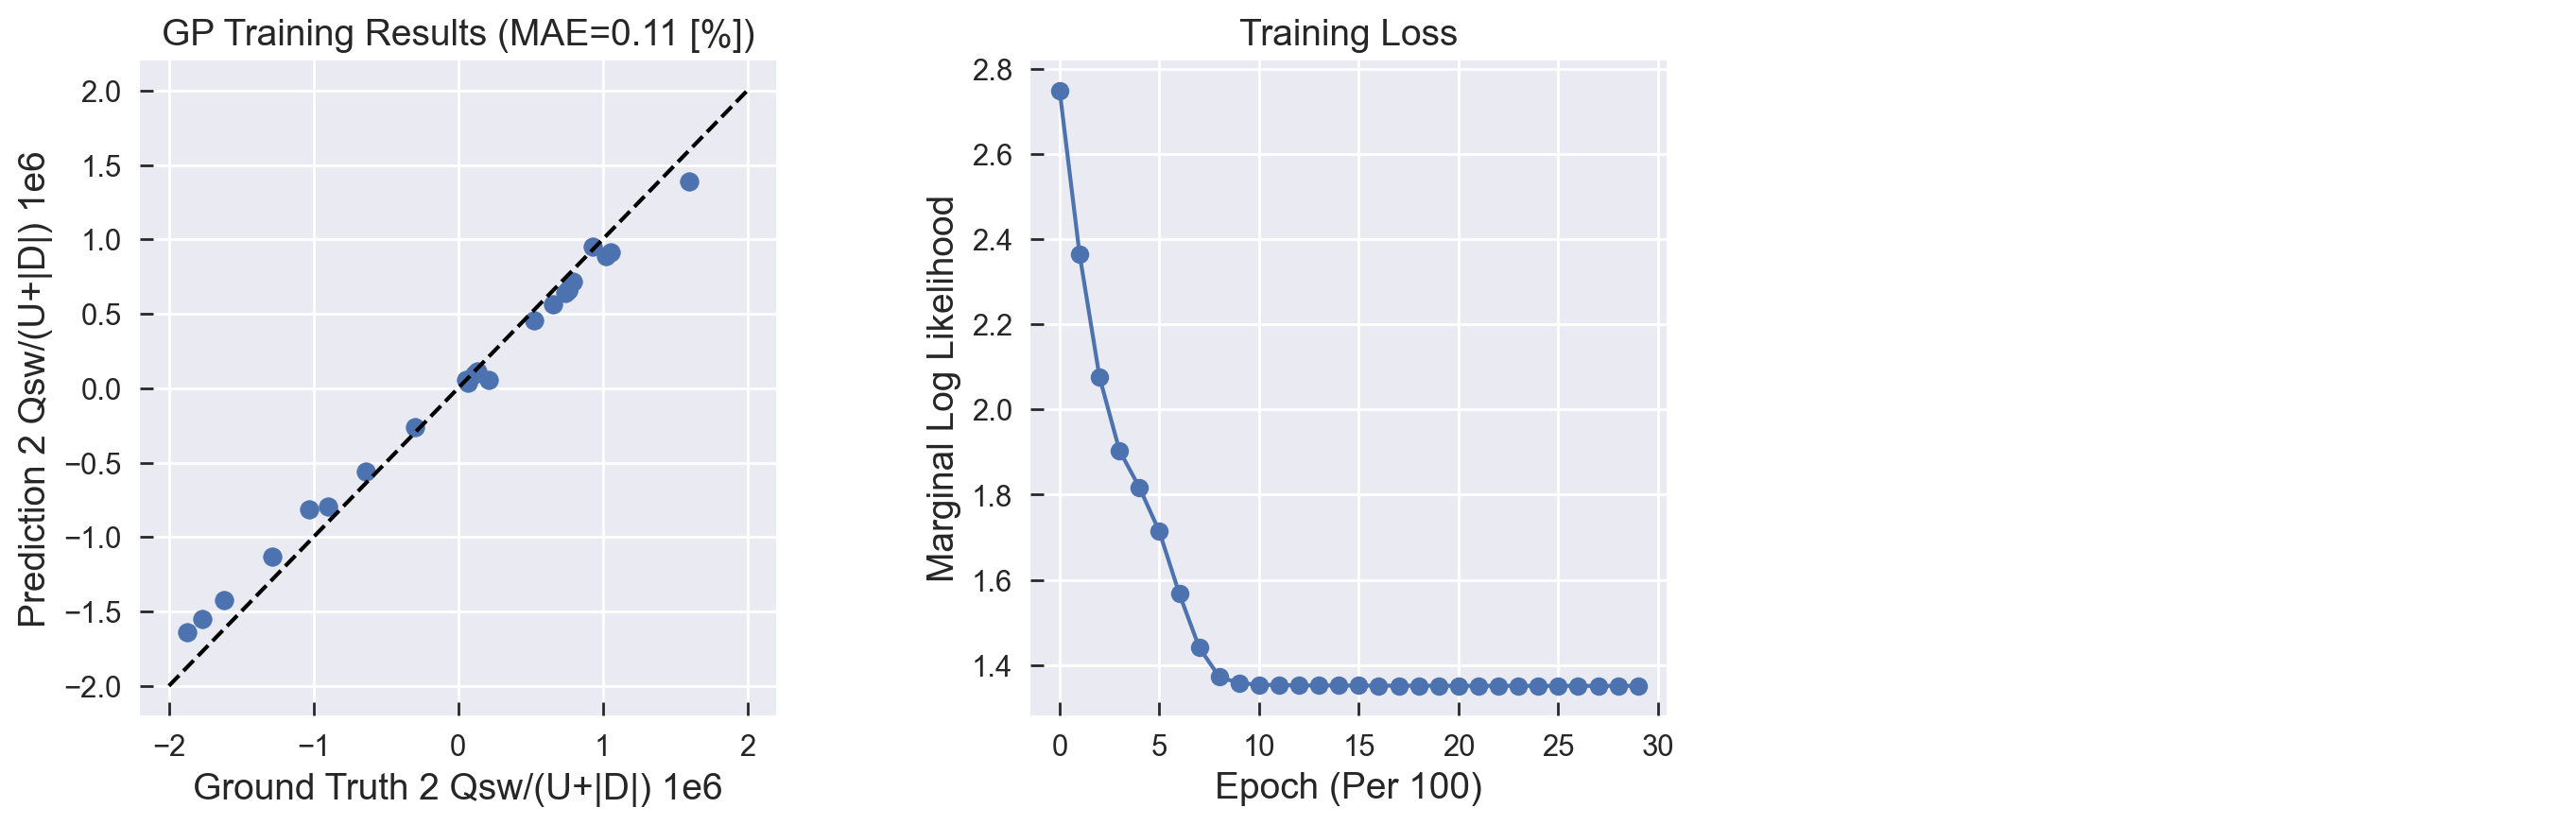

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt 
from plotter import prettyplot

round_three = lambda val: np.round(val, 3) 
y_preds = likelihood(model(train_x))
prettyplot()

# plot training results
with torch.no_grad():
    y_preds_mean = y_preds.mean.numpy()
    fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
    fs = 14

    # calculate error metrics
    rmse = np.sqrt(mean_squared_error(train_y, y_preds_mean))
    mae = mean_absolute_error(train_y,  y_preds_mean)
    spearman = spearmanr(train_y, y_preds_mean)[0]
    r2 = r2_score(train_y, y_preds_mean)
    err_vals = [round_three(i) for i in [rmse, mae, spearman, r2]]

    # print error metrics
    data = {'Metric': ['MAE', 'RMSE', 'Spearman', 'R² score'], 'Value': err_vals}
    df = pd.DataFrame(data)
    print(df)

    # training versus actuals plot: make plot, set title and axes values
    axes[0].scatter(train_y, y_preds_mean)
    axes[0].plot(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5), 'k--')
    axes[0].set_xlabel('Ground Truth 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    axes[0].set_ylabel('Prediction 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    axes[0].set_title('GP Training Results' + " (MAE=%.2f" % mae+' [%])', fontsize = fs)

    # loss plot: make plot, set title and axes values
    axes[1].plot(loss_lst, 'o-')
    title = 'Training Loss'
    axes[1].set_xlabel('Epoch (Per 100)', fontsize = fs)
    axes[1].set_ylabel('Marginal Log Likelihood', fontsize = fs)
    axes[1].set_title(title, fontsize = fs)
    axes[2].axis("off")

    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8)
    plt.subplots_adjust(wspace = 0.4)

    plt.show()

In [34]:
# acquisition function for prediction/exploration
def get_bounds(n): return [n for i in range(config.dim)]

def unravel_acq(acq_func, obs, bounds, train_y, nshape):
    """ 
    [unravel_acq(acq_func, obs, bounds, train_y, nshape)] is a helper function 
    for acq. 
    """
    acq = acq_func(obs, bounds, train_y).detach().numpy().reshape(nshape).T
    return np.unravel_index(acq.argmax(), acq.shape)

def acq(obs, train_y, bounds):
    """ 
    [acq(obs, train_y, bounds)] evaluates acquisition functions on current 
    predictions (observations) and outputs suggested points for exploration 
    on manifold. 
    """
    transpose = lambda tensor: tensor.detach().numpy().reshape(nshape).T
    nshape = tuple(bounds)

    pi = unravel_acq(PI, obs, bounds, train_y, nshape) # prob of improvement
    ei = unravel_acq(EI, obs, bounds, train_y, nshape) # expected improvement
    ca = unravel_acq(cust_acq, obs, bounds, train_y, nshape) # custom acq
    th = unravel_acq(thompson, obs, bounds, train_y, nshape) # thompson acq

    lower, upper = obs.confidence_region()
    upper_surf, lower_surf = transpose(upper), transpose(lower)
    ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)

    pred_var = obs.variance.view(nshape).detach().numpy().T
    pred_labels = obs.mean.view(nshape)
    max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)

    # acqs gives pairs corresponding to time and energy density recommendations
    # pairs index into pred_labels 
    acqs = {"PI":pi, "EI":ei, "CA":ca, "TH":th, "UCB":ucb, "Max_var":max_var}

    return pred_labels, upper_surf, lower_surf, acqs

In [35]:
# export predictions to csv
def pred_to_csv(acqs, raw_pred_labels, raw_test_grid):
    """
    [pred_to_csv(acqs, raw_pred_labels, raw_test_grid)] outputs suggested
    inputs and their respective predicted outputs to csv. 
    """   
    dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
    file = open(dir + "preds.csv", "w", encoding="utf-8")
    
    file.write("Energy density \t Time (ms)\n")
    for lab, pred in acqs.items():
        file.write(lab + ": " + str(raw_test_grid[pred[1]].tolist()[0]) + "\t" + str(raw_test_grid[pred[0]].tolist()[1]) + "\n")
    
    file.write("\nFigure of merit\n")
    for lab, pred in acqs.items():
        file.write(lab + ": " + str(raw_pred_labels[pred].item()) + "\n")

In [36]:
# get normalized predictions
bounds = get_bounds(n=30)
pred_labels, upper_surf, lower_surf, acqs = acq(obs, train_y, bounds)

# undo normalization
raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels, raw_upper_surf, raw_lower_surf = un_norm_all(x_sd_mean, y_sd_mean, train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf)

### Save Predictions and Visualize 

In [37]:
# undo normalization and save to csv
pred_to_csv(acqs, raw_pred_labels, raw_test_grid)

In [39]:
# visualize predictions and acquistion manifolds
vis_pred(raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels)
vis_acq(raw_train_x, raw_train_y, raw_test_grid, raw_pred_labels, raw_upper_surf, raw_lower_surf, acqs)